In [1]:

"""
derive_from_linkmatrix.py
-------------------------
Read a minimal stent spec (PARAMETERS + LINK MATRIX + GAP POLICY) and derive:
- pitch, circumference
- gap matrix (from policy + link matrix)
- per-column scale to close 8.000 mm
- ring heights (ring × column)
- crown geometry per cell using dual-tangent quarter-rectangle model
- dynamic horizontal keep-out from straight-leg tangency
- internal vertical cell edges so chords are exactly M = s_center + w/2 inside
- per-cell chords (centerline) for left & right crowns
- export derived JSON + Excel

Usage:
  python derive_from_linkmatrix.py /path/to/stent_min_spec.json
Outputs:
  derived_[timestamp].json and derived_[timestamp].xlsx in same folder.
"""
import sys, json, math
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter

def load_spec(path: Path):
    with open(path, "r") as f:
        return json.load(f)

def gaps_from_policy(link_matrix, gp):
    # link_matrix shape: 5 x C
    I, C = link_matrix.shape
    gaps = np.zeros_like(link_matrix, dtype=float)
    for i in range(I):
        for j in range(C):
            linked = (link_matrix[i, j] == 1)
            if i in (1,2,3):  # interior interfaces 2-3,3-4,4-5
                gaps[i, j] = gp["body_linked_mm"] if linked else gp["body_unlinked_mm"]
            else:
                # ends: i=0 is 1-2 (prox), i=4 is 5-6 (dist)
                if linked:
                    gaps[i, j] = gp["end_linked_mm"]
                else:
                    gaps[i, j] = gp["end_unlinked_prox_mm"] if i == 0 else gp["end_unlinked_dist_mm"]
    return gaps

def solve_delta_quarter(H_full, W_full, w, Rc, max_iter=120):
    """Solve tan δ = 2*(Hq - w/2 - Rc*(1 - cos δ)) / (Wq - 2 Rc sin δ) for quarter-rectangle geometry."""
    Hq = 0.5*H_full
    Wq = 0.5*W_full
    p = 0.5*w
    A = Hq - p
    # Function
    def F(d):
        s = math.sin(d); c = math.cos(d)
        denom = Wq - 2.0*Rc*s
        if abs(denom) < 1e-14:
            denom = 1e-14 if denom >= 0 else -1e-14
        return math.tan(d) - (2.0*(A - Rc*(1.0 - c))) / denom
    # bracket + bisection
    lo, hi = math.radians(5.0), math.radians(89.9)
    step = math.radians(0.05)
    # coarse search for sign change or best
    best_d, best_val = lo, abs(F(lo))
    prev_d, prev_f = lo, F(lo)
    bracket = None
    d = lo + step
    while d <= hi + 1e-12:
        fd = F(d)
        if abs(fd) < best_val: best_val, best_d = abs(fd), d
        if prev_f * fd < 0: bracket = (prev_d, d); break
        prev_d, prev_f = d, fd
        d += step
    if bracket is None:
        span = math.radians(5.0)
        lo = max(math.radians(1e-6), best_d - 0.5*span)
        hi = min(math.radians(89.9),   best_d + 0.5*span)
    else:
        lo, hi = bracket
    flo = F(lo)
    for _ in range(max_iter):
        mid = 0.5*(lo+hi); fm = F(mid)
        if abs(fm) < 1e-14 or (hi-lo) < 1e-12: return mid
        if flo * fm < 0.0:
            hi = mid
        else:
            lo = mid; flo = fm
    return 0.5*(lo+hi)

def compute_from_min_spec(spec: dict):
    P = spec["parameters"]
    gp = spec["gaps_policy"]
    links = spec["links"]
    D = float(P["diameter_mm"]); L = float(P["length_mm"])
    R_factor = float(P["R_factor"])
    xk_min = float(P.get("x_keepout_min_mm", 0.010))
    num_rings = int(P["num_rings"]); C = int(P["crowns_per_ring"])
    w_by_ring = list(map(float, P["strut_width_mm_by_ring"]))
    factors = list(map(float, P["height_factors"]))
    assert len(w_by_ring) == num_rings
    assert len(factors) == num_rings

    circumference = math.pi * D
    pitch = circumference / C
    link_matrix = np.array(links["matrix"], dtype=int)  # 5 x C
    assert link_matrix.shape == (num_rings-1, C)

    # 1) Gaps matrix from policy
    gaps_mat = gaps_from_policy(link_matrix, gp)  # (5 x C)
    sum_gaps_col = gaps_mat.sum(axis=0)          # (C,)
    Fsum = sum(factors)
    # 2) Per-column scale to close L
    scale_col = (L - sum_gaps_col) / Fsum        # (C,)

    # 3) Ring heights & stack positions per column
    H = np.zeros((num_rings, C))
    y_top = np.zeros((num_rings, C))
    y_bot = np.zeros((num_rings, C))
    for c in range(C):
        y = 0.0
        for r in range(num_rings):
            H[r, c] = factors[r] * scale_col[c]
            y_top[r, c] = y
            y += H[r, c]
            y_bot[r, c] = y
            if r < num_rings - 1:
                y += gaps_mat[r, c]

    # 4) Per-cell geometry & dynamic keepout from tangency
    cells = []
    for r in range(num_rings):
        w = w_by_ring[r]; Rc = R_factor * w
        for c in range(C):
            x_left  = c * pitch; x_right = (c+1) * pitch
            y_top_chord = float(y_top[r, c]); y_bot_chord = float(y_bot[r, c])
            H_full = float(H[r, c])
            # Solve crown quarter
            delta = solve_delta_quarter(H_full, pitch, w, Rc)
            theta = 2.0*delta
            c_center = 2.0*Rc*math.sin(delta)
            s_center = Rc*(1.0 - math.cos(delta))
            # M margin per your spec
            M = s_center + 0.5*w
            # Internal vertical edges
            y_top_edge = max(0.0, min(L, y_top_chord + M))
            y_bottom_edge = max(0.0, min(L, y_bot_chord - M))
            # Phase rule (left/right positions for top/bottom)
            ring_parity = ((r+1) % 2 == 1)   # rings 1,3,5 True
            col_parity  = (c % 2 == 0)       # even columns True
            use_base = (ring_parity == col_parity)
            left_pos, right_pos = (("bottom","top") if use_base else ("top","bottom"))
            yL = y_top_chord if left_pos == "top" else y_bot_chord
            yR = y_top_chord if right_pos == "top" else y_bot_chord
            # Tangency-based keepout for a straight leg
            tan_delta = math.tan(delta)
            if tan_delta < 1e-8:
                xk_raw = (pitch - 2.0*c_center)/2.0
            else:
                xk_raw = 0.5*(pitch - 2.0*c_center - H_full/tan_delta)
            xk_max = max(0.0, (pitch - 2.0*c_center)/2.0)
            xk = max(xk_min, min(xk_raw, xk_max))
            # Chords (centerline) with keepout
            left_cl  = [[x_left + xk, yL], [x_left + xk + c_center, yL]]
            right_cl = [[x_right - xk - c_center, yR], [x_right - xk, yR]]
            # Diagnostics
            dx = (right_cl[0][0] - left_cl[1][0]); dy = (yR - yL)
            alpha = math.atan2(dy, dx) if abs(dx) > 1e-12 else (math.pi/2.0)
            cells.append({
                "ring": r+1, "col": c,
                "x_left_mm": round(x_left, 6), "x_right_mm": round(x_right, 6),
                "y_top_edge_mm": round(y_top_edge, 6), "y_bottom_edge_mm": round(y_bottom_edge, 6),
                "left_crown_pos": left_pos, "right_crown_pos": right_pos,
                "left_cl": [[round(left_cl[0][0], 6), round(left_cl[0][1], 6)],
                            [round(left_cl[1][0], 6), round(left_cl[1][1], 6)]],
                "right_cl": [[round(right_cl[0][0], 6), round(right_cl[0][1], 6)],
                             [round(right_cl[1][0], 6), round(right_cl[1][1], 6)]],
                "Rc_mm": round(Rc, 6), "theta_deg": round(math.degrees(theta), 6),
                "delta_deg": round(math.degrees(delta), 6),
                "chord_center_len_mm": round(c_center, 6),
                "sagitta_center_mm": round(s_center, 6),
                "M_mm": round(M, 6),
                "x_keepout_mm": round(xk, 6), "x_keepout_raw_mm": round(xk_raw, 6), "x_keepout_max_mm": round(xk_max, 6),
                "alpha_deg": round(math.degrees(alpha), 6)
            })
    derived = {
        "meta": {"generated_at": datetime.now().isoformat(timespec="seconds"), "units": "mm (angles in deg)"},
        "parameters": {
            **P,
            "circumference_mm": circumference,
            "pitch_mm": pitch
        },
        "links": spec["links"],
        "gaps_policy": gp,
        "gaps_matrix": gaps_mat.tolist(),
        "sum_gaps_in_col_mm": [float(x) for x in sum_gaps_col],
        "scale_mm_per_factor_by_col": [float(x) for x in scale_col],
        "ring_heights_mm": H.tolist(),
        "stack_positions_by_column": [
            {
                "col": c,
                "ring_top_y_mm": [float(y_top[r, c]) for r in range(num_rings)],
                "ring_bottom_y_mm": [float(y_bot[r, c]) for r in range(num_rings)],
                "y_bottom_of_stent_mm": float(y_bot[-1, c])
            }
            for c in range(C)
        ],
        "cells": cells
    }
    return derived

def export_excel(derived: dict, out_xlsx: Path):
    # Build DataFrames
    P = derived["parameters"]
    df_params = pd.DataFrame([
        ["diameter_mm", P["diameter_mm"], "mm", "Expanded OD"],
        ["length_mm", P["length_mm"], "mm", "Total axial length"],
        ["num_rings", P["num_rings"], "", "Axial rings"],
        ["crowns_per_ring", P["crowns_per_ring"], "", "Crowns per ring (columns)"],
        ["circumference_mm", P["circumference_mm"], "mm", "π·D"],
        ["pitch_mm", P["pitch_mm"], "mm", "circumference / N"],
        ["R_factor", P["R_factor"], "", "Rc = R_factor × w"],
        ["x_keepout_min_mm", P.get("x_keepout_min_mm", 0.010), "mm", "Min lateral keep-out"],
    ], columns=["Parameter","Value","Units","Notes"])

    df_links = pd.DataFrame(derived["links"]["matrix"], columns=[f"col_{j}" for j in derived["links"]["matrix_cols"]])
    df_links.insert(0, "interface", derived["links"]["interfaces"])

    df_gaps = pd.DataFrame(derived["gaps_matrix"], columns=[f"col_{j}" for j in derived["links"]["matrix_cols"]])
    df_gaps.insert(0, "interface", derived["links"]["interfaces"])

    df_scale = pd.DataFrame({
        "col": list(range(P["crowns_per_ring"])),
        "sum_gaps_in_col_mm": derived["sum_gaps_in_col_mm"],
        "scale_mm_per_factor": derived["scale_mm_per_factor_by_col"],
    })

    # Ring heights as flat rows
    rh_rows = []
    H = derived["ring_heights_mm"]
    for r_idx, row in enumerate(H, start=1):
        rh_rows.append({"ring": r_idx, **{f"col_{c}": row[c] for c in range(P["crowns_per_ring"])}})
    df_rh = pd.DataFrame(rh_rows)

    # Cells table
    def flat_cell(cell):
        d = {
            "ring": cell["ring"], "col": cell["col"],
            "x_left_mm": cell["x_left_mm"], "x_right_mm": cell["x_right_mm"],
            "y_top_edge_mm": cell["y_top_edge_mm"], "y_bottom_edge_mm": cell["y_bottom_edge_mm"],
            "left_pos": cell["left_crown_pos"], "right_pos": cell["right_crown_pos"],
            "Rc_mm": cell["Rc_mm"], "theta_deg": cell["theta_deg"], "delta_deg": cell["delta_deg"],
            "c_center_mm": cell["chord_center_len_mm"], "s_center_mm": cell["sagitta_center_mm"],
            "M_mm": cell["M_mm"], "x_keepout_mm": cell["x_keepout_mm"],
            "x_keepout_raw_mm": cell["x_keepout_raw_mm"], "x_keepout_max_mm": cell["x_keepout_max_mm"],
            "alpha_deg": cell["alpha_deg"],
        }
        (x1,y1),(x2,y2) = cell["left_cl"]
        d.update({"left_cl_x1": x1, "left_cl_y": y1, "left_cl_x2": x2})
        (x1,y1),(x2,y2) = cell["right_cl"]
        d.update({"right_cl_x1": x1, "right_cl_y": y1, "right_cl_x2": x2})
        return d
    df_cells = pd.DataFrame([flat_cell(c) for c in derived["cells"]])

    with pd.ExcelWriter(out_xlsx, engine="openpyxl") as writer:
        pd.DataFrame([
            ["Parameters", "Global inputs, derived pitch/circumference."],
            ["LinkMatrix", "Interfaces×columns: 1=link, 0=no link."],
            ["GapsMatrix", "Derived from LinkMatrix + GapsPolicy."],
            ["ColumnScale", "Per-column scale to close L."],
            ["RingHeights", "Ring heights (mm) by column."],
            ["Cells", "Per-cell chords, edges, keep-out & geometry."],
        ], columns=["sheet","purpose"]).to_excel(writer, sheet_name="KEY", index=False)
        df_params.to_excel(writer, sheet_name="Parameters", index=False)
        df_links.to_excel(writer, sheet_name="LinkMatrix", index=False)
        df_gaps.to_excel(writer, sheet_name="GapsMatrix", index=False)
        df_scale.to_excel(writer, sheet_name="ColumnScale", index=False)
        df_rh.to_excel(writer, sheet_name="RingHeights", index=False)
        df_cells.to_excel(writer, sheet_name="Cells", index=False)

    wb = load_workbook(out_xlsx)
    def set_width(wsname, widths):
        ws = wb[wsname]; ws.freeze_panes = "A2"
        for i, w in enumerate(widths, start=1):
            ws.column_dimensions[get_column_letter(i)].width = w
    set_width("KEY", [24, 84])
    set_width("Parameters", [28, 16, 10, 44])
    set_width("LinkMatrix", [16] + [10]* (1 + derived["parameters"]["crowns_per_ring"]))
    set_width("GapsMatrix", [16] + [10]* (1 + derived["parameters"]["crowns_per_ring"]))
    set_width("ColumnScale", [10, 22, 22])
    set_width("RingHeights", [10] + [14]* (derived["parameters"]["crowns_per_ring"]))
    set_width("Cells", [8,8,14,14,14,14, 10,10, 10,10,10, 12,12,12, 12,12,12, 12,12,12])
    wb.save(out_xlsx)




In [ ]:
def main():
    if len(sys.argv) < 2:
        print("Usage: python derive_from_linkmatrix.py /path/to/stent_min_spec.json")
        sys.exit(1)
    in_path = Path(sys.argv[1]).expanduser().resolve()
    spec = load_spec(in_path)
    derived = compute_from_min_spec(spec)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_json = in_path.parent / f"derived_{ts}.json"
    out_xlsx = in_path.parent / f"derived_{ts}.xlsx"
    with open(out_json, "w") as f:
        json.dump(derived, f, indent=2)
    export_excel(derived, out_xlsx)
    print(str(out_json))
    print(str(out_xlsx))

if __name__ == "__main__":
    main()

In [3]:
# Run the derive_link_matrix code with the available JSON file
import os
from pathlib import Path

# Path to the minimal spec JSON file (use absolute path)
json_file_path = Path("d:/SynologyDrive/Projects/VisualStudio/Fusion/stent/stent_frame/commands/gptDataProcessor/stent_min_spec_20250907_170133.json")

print("🚀 RUNNING DERIVE_LINK_MATRIX")
print("=" * 50)

# Check if file exists
if json_file_path.exists():
    print(f"📁 Using JSON file: {json_file_path.name}")
    
    # Load the spec
    spec = load_spec(json_file_path)
    print(f"✅ Loaded spec with {spec['parameters']['num_rings']} rings and {spec['parameters']['crowns_per_ring']} crowns per ring")
    
    # Compute derived geometry
    print("🔧 Computing derived geometry...")
    derived = compute_from_min_spec(spec)
    
    # Generate output filenames with timestamp
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_json = f"derived_{ts}.json"
    out_xlsx = f"derived_{ts}.xlsx"
    
    # Save JSON output
    print(f"💾 Saving derived JSON: {out_json}")
    with open(out_json, "w") as f:
        json.dump(derived, f, indent=2)
    
    # Export to Excel
    print(f"📊 Exporting to Excel: {out_xlsx}")
    export_excel(derived, Path(out_xlsx))
    
    print("\\n✅ SUCCESS!")
    print(f"📄 Generated files:")
    print(f"   📋 JSON: {out_json}")
    print(f"   📊 Excel: {out_xlsx}")
    
    # Display summary
    print(f"\\n📊 DERIVED GEOMETRY SUMMARY:")
    print(f"   🔧 Total cells: {len(derived['cells'])}")
    print(f"   📐 Circumference: {derived['parameters']['circumference_mm']:.4f} mm")
    print(f"   📏 Pitch: {derived['parameters']['pitch_mm']:.4f} mm")
    print(f"   🎯 Rings: {derived['parameters']['num_rings']}")
    print(f"   🔄 Crowns per ring: {derived['parameters']['crowns_per_ring']}")
    
    # Show first few cells as verification
    print(f"\\n🔍 SAMPLE CELLS (first 3):")
    for i, cell in enumerate(derived['cells'][:3]):
        print(f"   Cell {i+1}: R{cell['ring']}C{cell['col']} - Keepout: {cell['x_keepout_mm']:.4f}mm, Theta: {cell['theta_deg']:.2f}°")
    
else:
    print(f"❌ JSON file not found: {json_file_path}")
    print("Looking for JSON files...")
    # Search for JSON files in the directory
    json_dir = Path("d:/SynologyDrive/Projects/VisualStudio/Fusion/stent/stent_frame/commands/gptDataProcessor/")
    if json_dir.exists():
        json_files = list(json_dir.glob("*.json"))
        if json_files:
            print("Found JSON files:")
            for f in json_files:
                print(f"   📄 {f.name}")
        else:
            print("No JSON files found in directory")

🚀 RUNNING DERIVE_LINK_MATRIX
📁 Using JSON file: stent_min_spec_20250907_170133.json
✅ Loaded spec with 6 rings and 8 crowns per ring
🔧 Computing derived geometry...
💾 Saving derived JSON: derived_20250907_121333.json
📊 Exporting to Excel: derived_20250907_121333.xlsx
\n✅ SUCCESS!
📄 Generated files:
   📋 JSON: derived_20250907_121333.json
   📊 Excel: derived_20250907_121333.xlsx
\n📊 DERIVED GEOMETRY SUMMARY:
   🔧 Total cells: 48
   📐 Circumference: 5.6549 mm
   📏 Pitch: 0.7069 mm
   🎯 Rings: 6
   🔄 Crowns per ring: 8
\n🔍 SAMPLE CELLS (first 3):
   Cell 1: R1C0 - Keepout: 0.0178mm, Theta: 173.95°
   Cell 2: R1C1 - Keepout: 0.0181mm, Theta: 174.11°
   Cell 3: R1C2 - Keepout: 0.0179mm, Theta: 173.97°


🎨 VISUALIZING DERIVED STENT GEOMETRY
📊 Loaded 48 cells
🔧 Diameter: 1.8 mm
📏 Length: 8.0 mm
🎯 Circumference: 5.6549 mm
📐 Pitch: 0.7069 mm


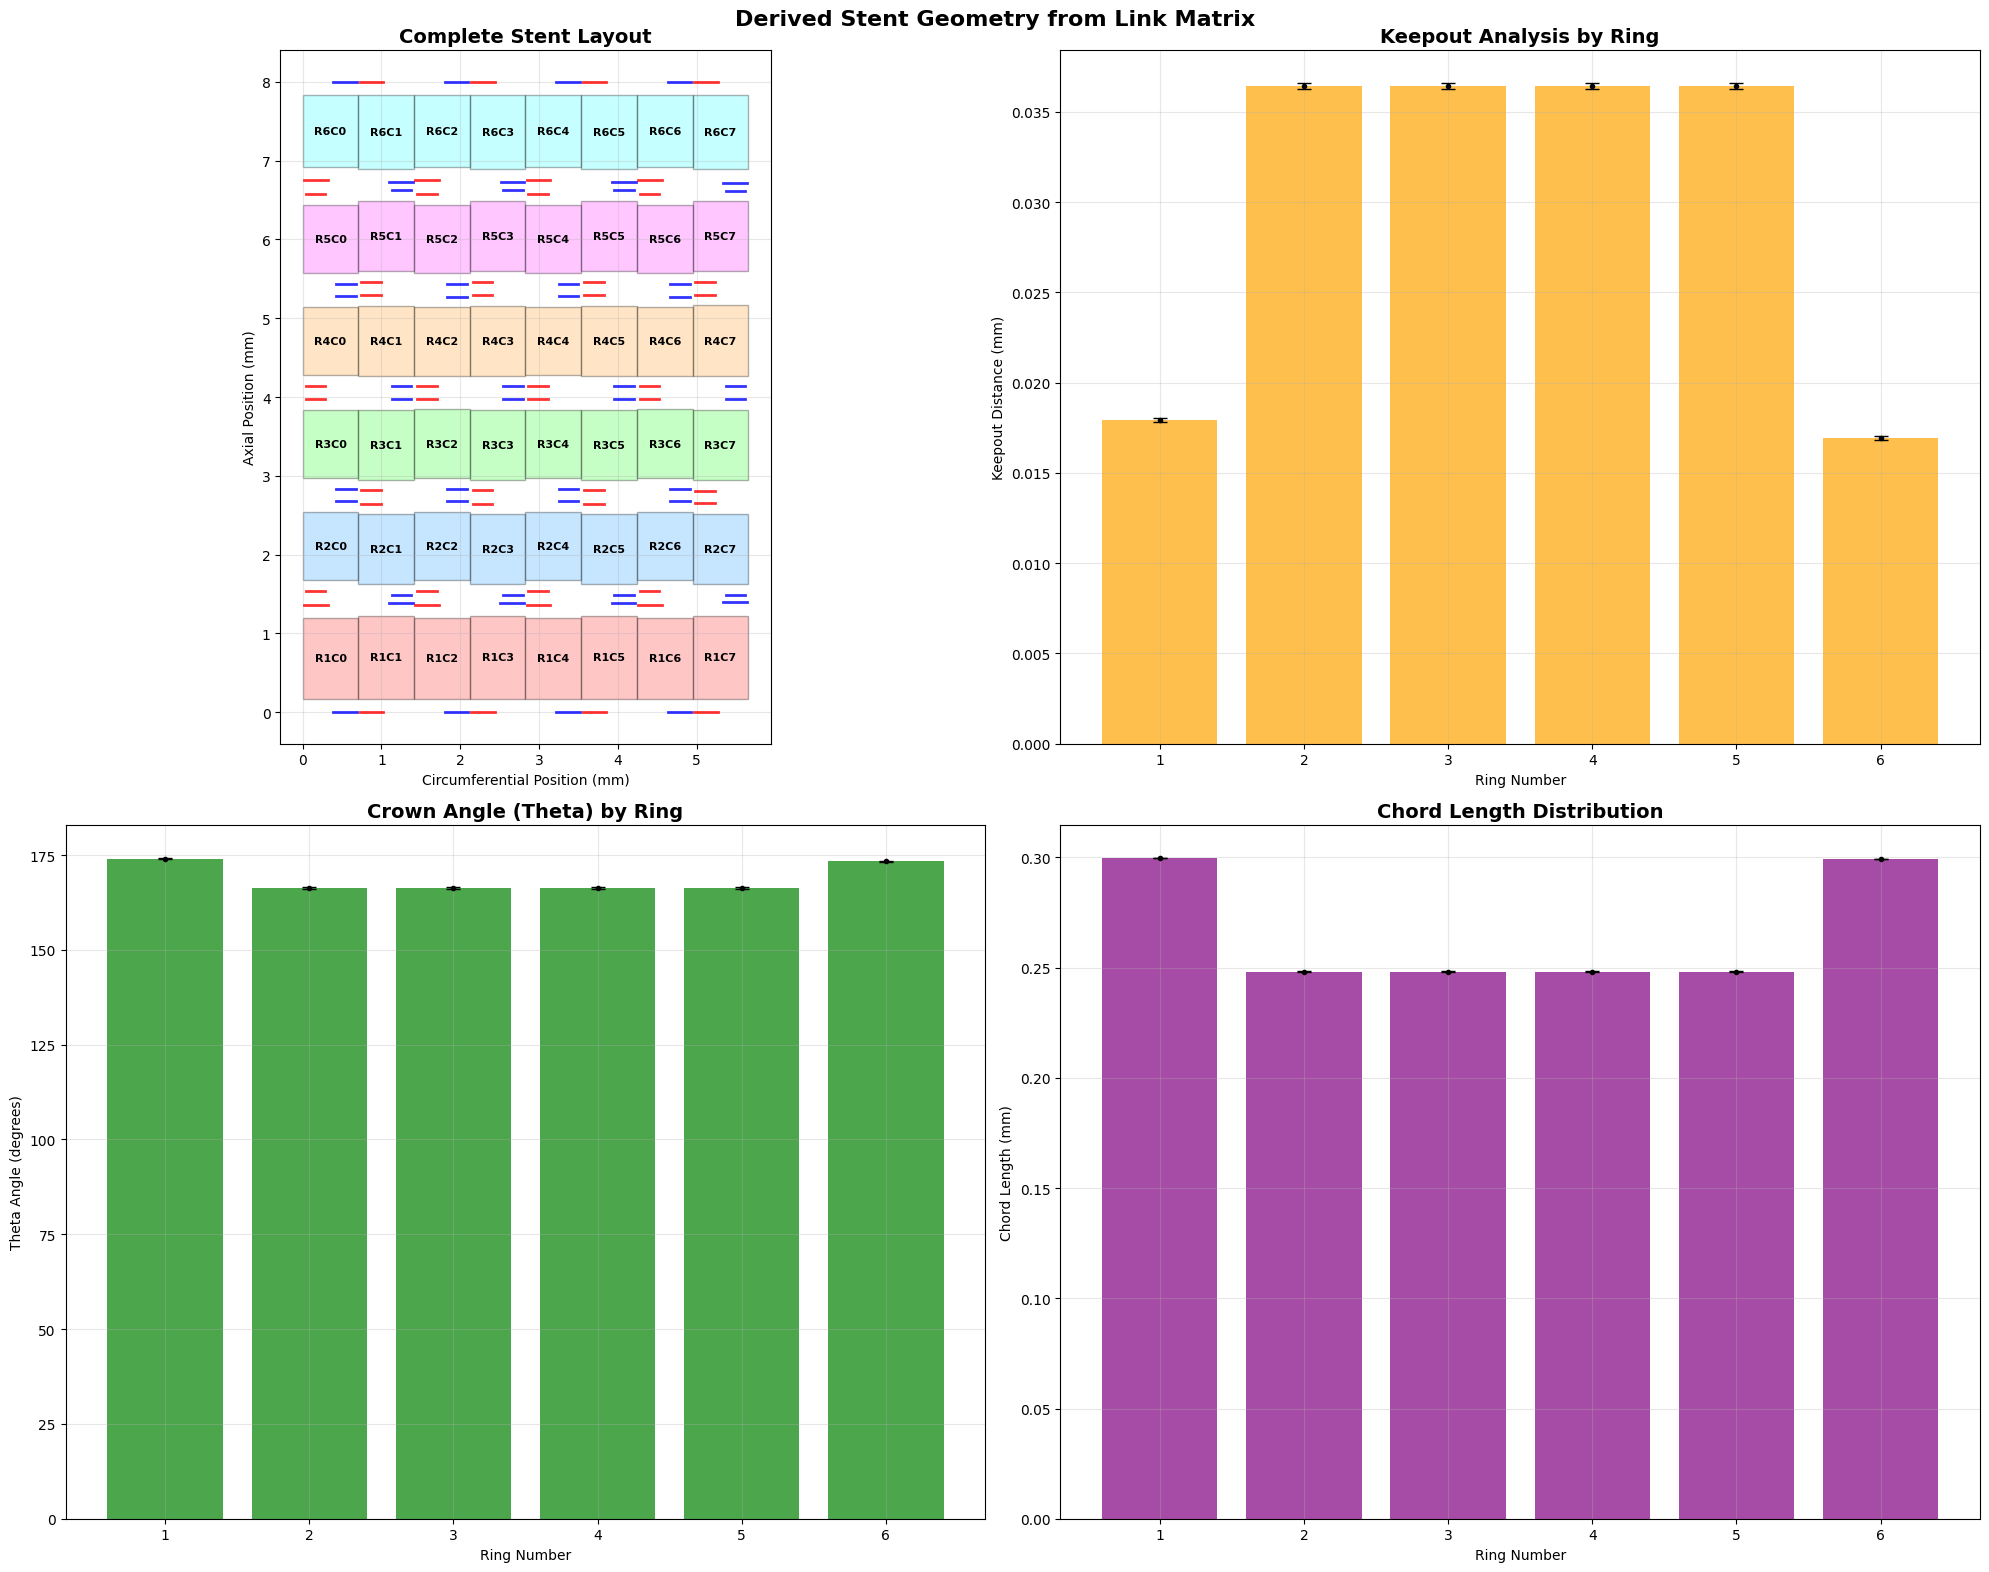

\n✅ Visualization complete!
🎯 Key insights:
   📏 Average keepout: 0.0301 ± 0.0089 mm
   📐 Average theta: 168.78 ± 3.46°
   🎯 Average chord: 0.2653 ± 0.0242 mm


In [4]:
# Load and display the newly generated derived JSON
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the generated JSON file
with open("derived_20250907_121333.json", "r") as f:
    derived_data = json.load(f)

print("🎨 VISUALIZING DERIVED STENT GEOMETRY")
print("=" * 60)

# Extract cells data
cells = derived_data['cells']
params = derived_data['parameters']

print(f"📊 Loaded {len(cells)} cells")
print(f"🔧 Diameter: {params['diameter_mm']} mm")
print(f"📏 Length: {params['length_mm']} mm")
print(f"🎯 Circumference: {params['circumference_mm']:.4f} mm")
print(f"📐 Pitch: {params['pitch_mm']:.4f} mm")

# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Derived Stent Geometry from Link Matrix', fontsize=16, fontweight='bold')

# Plot 1: Complete stent layout
ax1.set_title('Complete Stent Layout', fontsize=14, fontweight='bold')
ring_colors = ['#FF4444', '#44AAFF', '#44FF44', '#FFAA44', '#FF44FF', '#44FFFF']

for i, cell in enumerate(cells):
    ring = cell['ring'] - 1  # Convert to 0-based index
    color = ring_colors[ring % len(ring_colors)]
    
    # Cell boundaries
    x_left = cell['x_left_mm']
    x_right = cell['x_right_mm']
    y_top = cell['y_top_edge_mm']
    y_bottom = cell['y_bottom_edge_mm']
    
    width = x_right - x_left
    height = y_bottom - y_top
    
    # Draw cell
    rect = patches.Rectangle((x_left, y_top), width, height,
                           linewidth=1, edgecolor='black',
                           facecolor=color, alpha=0.3)
    ax1.add_patch(rect)
    
    # Draw chords
    left_cl = cell['left_cl']
    right_cl = cell['right_cl']
    
    ax1.plot([left_cl[0][0], left_cl[1][0]], [left_cl[0][1], left_cl[1][1]], 
             'r-', linewidth=2, alpha=0.8)
    ax1.plot([right_cl[0][0], right_cl[1][0]], [right_cl[0][1], right_cl[1][1]], 
             'b-', linewidth=2, alpha=0.8)
    
    # Cell labels
    center_x = (x_left + x_right) / 2
    center_y = (y_top + y_bottom) / 2
    ax1.text(center_x, center_y, f'R{cell["ring"]}C{cell["col"]}', 
             ha='center', va='center', fontsize=8, fontweight='bold')

ax1.set_xlabel('Circumferential Position (mm)')
ax1.set_ylabel('Axial Position (mm)')
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')

# Plot 2: Keepout analysis
ax2.set_title('Keepout Analysis by Ring', fontsize=14, fontweight='bold')
rings = [cell['ring'] for cell in cells]
keepouts = [cell['x_keepout_mm'] for cell in cells]

# Group by ring
ring_keepouts = {}
for ring, keepout in zip(rings, keepouts):
    if ring not in ring_keepouts:
        ring_keepouts[ring] = []
    ring_keepouts[ring].append(keepout)

ring_nums = sorted(ring_keepouts.keys())
mean_keepouts = [np.mean(ring_keepouts[r]) for r in ring_nums]
std_keepouts = [np.std(ring_keepouts[r]) for r in ring_nums]

ax2.bar(ring_nums, mean_keepouts, alpha=0.7, color='orange')
ax2.errorbar(ring_nums, mean_keepouts, yerr=std_keepouts, 
             fmt='k.', capsize=5)
ax2.set_xlabel('Ring Number')
ax2.set_ylabel('Keepout Distance (mm)')
ax2.grid(True, alpha=0.3)

# Plot 3: Theta angle distribution
ax3.set_title('Crown Angle (Theta) by Ring', fontsize=14, fontweight='bold')
thetas = [cell['theta_deg'] for cell in cells]

ring_thetas = {}
for ring, theta in zip(rings, thetas):
    if ring not in ring_thetas:
        ring_thetas[ring] = []
    ring_thetas[ring].append(theta)

mean_thetas = [np.mean(ring_thetas[r]) for r in ring_nums]
std_thetas = [np.std(ring_thetas[r]) for r in ring_nums]

ax3.bar(ring_nums, mean_thetas, alpha=0.7, color='green')
ax3.errorbar(ring_nums, mean_thetas, yerr=std_thetas, 
             fmt='k.', capsize=5)
ax3.set_xlabel('Ring Number')
ax3.set_ylabel('Theta Angle (degrees)')
ax3.grid(True, alpha=0.3)

# Plot 4: Chord length analysis
ax4.set_title('Chord Length Distribution', fontsize=14, fontweight='bold')
chord_lengths = [cell['chord_center_len_mm'] for cell in cells]

ring_chords = {}
for ring, chord in zip(rings, chord_lengths):
    if ring not in ring_chords:
        ring_chords[ring] = []
    ring_chords[ring].append(chord)

mean_chords = [np.mean(ring_chords[r]) for r in ring_nums]
std_chords = [np.std(ring_chords[r]) for r in ring_nums]

ax4.bar(ring_nums, mean_chords, alpha=0.7, color='purple')
ax4.errorbar(ring_nums, mean_chords, yerr=std_chords, 
             fmt='k.', capsize=5)
ax4.set_xlabel('Ring Number')
ax4.set_ylabel('Chord Length (mm)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n✅ Visualization complete!")
print("🎯 Key insights:")
print(f"   📏 Average keepout: {np.mean(keepouts):.4f} ± {np.std(keepouts):.4f} mm")
print(f"   📐 Average theta: {np.mean(thetas):.2f} ± {np.std(thetas):.2f}°")
print(f"   🎯 Average chord: {np.mean(chord_lengths):.4f} ± {np.std(chord_lengths):.4f} mm")